## Approach for this assignment

* **Factors** 

    * Experiment with two different approaches, maintaining the improvement of higher order polynomial terms from Assignment 4:

        * Start with a generic application of PCA on the dataset and then extract the most useful components from this using LASSO.
        * Start with the LASSO methodology deveoped previously, filter the predictors it selects through PCA, and then run LASSO again on its output.
        * A PLS approach.


* **Non-parametrics**
    
    * Feed the factors chosen by our most accurate factor model into a random forest.

## Install Packages

In [6]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio
import statsmodels.api as sm
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import  Lasso, LinearRegression,LassoCV, Ridge, ElasticNetCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.model_selection import LeaveOneOut
from itertools import combinations
import matplotlib.pyplot as plt

## Read Data

In [7]:
train_url = "https://github.com/joshcpld/ada/raw/main/Assignment%202/data/train_data.csv"
train_df = pd.read_csv(train_url)
test_url = "https://github.com/joshcpld/ada/raw/main/Assignment%202/data/test_data.csv"
test_df = pd.read_csv(test_url)

train_df.head() 

,ID,Y,X1,X2,X3,X4,X5,X6,X7,X8,...,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50
0,0,-1.399091,1.174139,1.413109,0.164693,-1.067338,0.015324,-1.280970,0.489681,-0.371982,...,-0.115044,-2.580043,-0.812428,0.772820,-0.460444,0.190422,-0.362052,-1.119038,0.916313,-1.517434
1,1,3.097990,0.208922,0.931231,0.838779,0.893483,-0.510555,0.900289,-0.042490,0.839400,...,1.155635,0.673035,-0.438152,-0.001316,-0.761800,1.335092,0.901978,-1.549504,-0.456224,0.223405
2,2,-1.707346,-0.744982,0.962118,0.615392,-0.427943,-0.014912,1.138781,1.159491,0.055467,...,0.299277,1.387495,-0.007519,-0.464825,0.830986,0.373124,0.319232,-0.577295,-1.363846,-0.347154
3,3,0.610625,-0.170428,-1.361771,0.206042,0.623124,0.907441,-0.873814,1.287383,0.901191,...,1.209247,0.095866,-0.287905,-1.110714,-1.660352,0.207231,-0.419119,-0.517563,-1.050697,-0.096327
4,4,-0.689196,-0.858792,0.321308,-0.415649,1.014056,-0.522858,0.926634,-0.390663,0.790054,...,-1.191989,-1.127448,0.246358,0.407769,1.132454,-0.016621,0.964745,0.091532,0.649593,-0.818020


Separate the X predictors from our outcome variable Y.

In [8]:
X0_train = train_df.drop(columns=['Y', 'ID'])
y0_train = train_df['Y'].values
x0_test = test_df.drop(columns=["ID"])
cols = X0_train.columns.tolist()

Insert higher order polynomial interaction terms/finalise training set

In [9]:
# Define function
def matrix(df, cols):
    # Original terms: X1, X2, ..., Xk
    base = df[cols].copy()

    # Squared (X^2), Cubic (X^3), Quartic (X^4) terms for each column
    squares  = pd.DataFrame({f"{c}^2": df[c]**2 for c in cols}, index=df.index)
    cubes    = pd.DataFrame({f"{c}^3": df[c]**3 for c in cols}, index=df.index)
    quartics = pd.DataFrame({f"{c}^4": df[c]**4 for c in cols}, index=df.index)

    # Interaction terms (keep exactly what you had)
    inter_dict = {}
    for i, c1 in enumerate(cols):
        for j in range(i + 1, len(cols)):
            c2 = cols[j]
            inter_dict[f"{c1}*{c2}"] = df[c1] * df[c2]
    inter = pd.DataFrame(inter_dict, index=df.index)

    # Combine all together (base → squares → cubes → quartics → interactions)
    X_vars = pd.concat([base, 
                        squares, 
                        cubes, 
                        quartics, 
                        inter], axis=1)

    return X_vars

# Create the polynomial (up to quartic) and interaction terms training set
X_vars_train = matrix(train_df, cols)
X_vars_test = matrix(test_df.drop(columns=['ID']), cols)

Dimensionality of original training set: (2400, 50)
Dimensionality of new training set: (2400, 1425)


# Factors

We have 3 models to estimate:

* PCA -> LASSO
* LASSO -> PCA -> LASSO
* PLS

## PCA -> LASSO

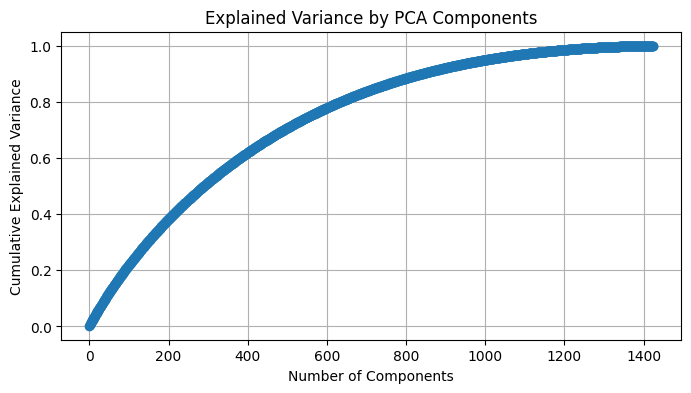

In [10]:
# Normalise the data
scaler = StandardScaler()
X1_train = scaler.fit_transform(X_vars_train.values)

# Fit PCA on the scaled training data
pca = PCA()
X_pca_full = pca.fit_transform(X1_train)

# Plot cumulative variance explained to decide number of components
plt.figure(figsize=(8,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by PCA Components")
plt.grid(True)
plt.show()

At around 900 components, PCA explains around 90% of the variances. Therefore, we choose $k$ = 900. The elbow method does not add much here, as we would effectively have to use all 1450 components to get to the point where the variance gain flattens most sharply. We consider this 90% threshold to be a reasonable trade-off between performance and persimony.

In [11]:
# Fit PCA with k = 900 components
k = 900
pca = PCA(n_components=k)
X_pca = pca.fit_transform(X1_train)  # PCA-transformed training matrix

# Set up 5-fold cross validation
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate Linear Regression using PCA-transformed features
lin_mse = [] # store MSE for each fold
for train_idx, val_idx in k_fold.split(X_pca):
    X_tr, X_va = X_pca[train_idx], X_pca[val_idx] # split predictors into train/val folds
    y_tr, y_va = y0_train[train_idx], y0_train[val_idx] # split target into train/val folds
    m = LinearRegression().fit(X_tr, y_tr) # fit linear regression on training fold
    yhat = m.predict(X_va) # predict validation fold
    lin_mse.append(mean_squared_error(y_va, yhat)) # compute fold MSE and store
lin_cv = float(np.mean(lin_mse)) # average CV error across folds

# Evaluate Ridge Regression across a grid of alpha values
alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
ridge_results = [] # store results for each alpha
for a in alphas:
    fold_mse = [] # store fold errors for this alpha
    for train_idx, val_idx in k_fold.split(X_pca):
        X_tr, X_va = X_pca[train_idx], X_pca[val_idx]
        y_tr, y_va = y0_train[train_idx], y0_train[val_idx]
        m = Ridge(alpha=a).fit(X_tr, y_tr) # fit ridge with this alpha
        yhat = m.predict(X_va)
        fold_mse.append(mean_squared_error(y_va, yhat))
    ridge_results.append({"alpha": a, "cv_mse": float(np.mean(fold_mse))}) # store mean error

ridge_df = pd.DataFrame(ridge_results).sort_values("cv_mse")
best_ridge_alpha = float(ridge_df.iloc[0]["alpha"]) # best alpha
best_ridge_cv = float(ridge_df.iloc[0]["cv_mse"])   # corresponding CV error

# Evaluate Lasso on PCA features
lasso_alphas = [1e-5, 5e-5, 1e-4, 5e-4, 0.001, 0.005, 0.01, 0.05]
lasso_results = []
for a in lasso_alphas:
    fold_mse = []
    lasso = Lasso(alpha=a, max_iter=10000)
    for train_idx, val_idx in k_fold.split(X_pca):
        X_tr, X_va = X_pca[train_idx], X_pca[val_idx]
        y_tr, y_va = y0_train[train_idx], y0_train[val_idx]
        lasso.fit(X_tr, y_tr)
        yhat = lasso.predict(X_va)
        fold_mse.append(mean_squared_error(y_va, yhat))
    lasso_results.append({"alpha": a, "cv_mse": float(np.mean(fold_mse))})

lasso_df = pd.DataFrame(lasso_results).sort_values("cv_mse")

# Summarise PCA model performance across different approaches
summary = pd.DataFrame([
    {"model": "Linear (PCA k=900)", "cv_mse": lin_cv},
    {"model": f"Ridge (PCA k=900, alpha={best_ridge_alpha})", "cv_mse": best_ridge_cv},
])
if not lasso_df.empty:
    summary = pd.concat([summary, pd.DataFrame(
        [{"model": f"Lasso (PCA k=900, alpha={row.alpha})", "cv_mse": row.cv_mse}
         for row in lasso_df.itertuples()]
    )], ignore_index=True)

# Sort and display models by CV error
summary.sort_values("cv_mse")


,model,cv_mse
1,"Ridge (PCA k=900, alpha=1000.0)",8.289194
2,"Lasso (PCA k=900, alpha=0.05)",8.741782
3,"Lasso (PCA k=900, alpha=0.01)",10.008481
4,"Lasso (PCA k=900, alpha=0.005)",10.749266
5,"Lasso (PCA k=900, alpha=0.001)",11.565803
6,"Lasso (PCA k=900, alpha=0.0005)",11.686580
7,"Lasso (PCA k=900, alpha=0.0001)",11.786914
8,"Lasso (PCA k=900, alpha=5e-05)",11.799679
9,"Lasso (PCA k=900, alpha=1e-05)",11.809941
0,Linear (PCA k=900),11.812514


# LASSO -> PCA -> LASSO